# 📊 Sailing Agent Model Comparison

This notebook loads all training results from the `results/` directory and facilitates comparison between different models and hyperparameters.

In [13]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import numpy as np

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Results Data

In [14]:
def load_results(results_dir="../results"):
    data = []
    
    if not os.path.exists(results_dir):
        print(f"Directory {results_dir} not found!")
        return pd.DataFrame()
    
    # Iterate over all JSON files
    for filename in os.listdir(results_dir):
        if filename.endswith(".json"):
            filepath = os.path.join(results_dir, filename)
            try:
                with open(filepath, 'r') as f:
                    result = json.load(f)
                
                # Flatten the structure
                entry = {
                    'filename': filename,
                    'timestamp': result.get('metadata', {}).get('timestamp', 'N/A'),
                    'agent': result.get('metadata', {}).get('agent', 'Unknown'),
                }
                
                # Add Evaluation Metrics (Overall)
                if 'evaluation' in result and 'training_1' in result['evaluation']:
                    # Assumes training_1 is present, or takes limits
                    # Ideally we want overall averaged metrics if available
                    # Let's try to find the 'overall' like stats if they were saved, or take average of scenarios
                    
                    # Check if we have the structured overall stats from recent update
                    first_scenario = list(result['evaluation'].keys())[0]
                    eval_data = result['evaluation'][first_scenario]
                    
                    entry['success_rate'] = eval_data.get('success_rate', 0) * 100 if eval_data.get('success_rate', 0) <= 1.0 else eval_data.get('success_rate', 0)
                    entry['avg_reward'] = eval_data.get('mean_reward', 0)
                    entry['avg_steps'] = eval_data.get('mean_steps', 0)
                    entry['custom_score'] = eval_data.get('custom_score', 0)
                
                elif 'training' in result:
                    # Fallback to training metrics if eval not present
                    entry['success_rate'] = result['training'].get('final_success_rate', 0) * 100
                    entry['avg_reward'] = result['training'].get('avg_reward', 0)
                    entry['avg_steps'] = result['training'].get('avg_steps', 0)
                    entry['custom_score'] = 0 # Not calculated during training

                # Add Hyperparameters
                if 'hyperparameters' in result:
                    for k, v in result['hyperparameters'].items():
                        entry[f'hp_{k}'] = v
                
                data.append(entry)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
    
    return pd.DataFrame(data)

df = load_results()
print(f"Loaded {len(df)} results.")
if not df.empty:
    # Sort by timestamp descending
    df = df.sort_values('timestamp', ascending=False)

# Display first few rows
df.head()

Loaded 1 results.


,filename,timestamp,agent,success_rate,avg_reward,avg_steps,custom_score,hp_learning_rate,hp_discount_factor,hp_exploration_rate,hp_position_bins,hp_velocity_bins,hp_wind_bins,hp_wind_preview_steps,hp_grid_size,hp_q_init_high
0,base_physic.json,20260119_214707,my_agent_physics,100.0,327.095581,1000.0,3.270956,0.15,0.8,0.05,10,5,8,3,32,10.0


## 2. Leaderboard 🏆

In [15]:
if not df.empty:
    # Select relevant columns for leaderboard
    cols = ['timestamp', 'agent', 'success_rate', 'avg_reward', 'avg_steps', 'custom_score']
    # Add hyperparam cols if they exist
    hp_cols = [c for c in df.columns if c.startswith('hp_')]
    cols.extend(hp_cols)
    
    leaderboard = df[cols].sort_values('custom_score', ascending=False)
    
    # Styling
    def highlight_best(s):
        is_max = s == s.max()
        return ['background-color: lightgreen' if v else '' for v in is_max]
    
    display(leaderboard.style.background_gradient(subset=['custom_score', 'success_rate'], cmap='Greens')\
                             .background_gradient(subset=['avg_steps'], cmap='Reds')\
                             .format({'success_rate': '{:.1f}%', 'avg_reward': '{:.1f}', 'avg_steps': '{:.1f}', 'custom_score': '{:.2f}'}))
else:
    print("No data available.")

,timestamp,agent,success_rate,avg_reward,avg_steps,custom_score,hp_learning_rate,hp_discount_factor,hp_exploration_rate,hp_position_bins,hp_velocity_bins,hp_wind_bins,hp_wind_preview_steps,hp_grid_size,hp_q_init_high
0,20260119_214707,my_agent_physics,100.0%,327.1,1000.0,3.27,0.150000,0.800000,0.050000,10,5,8,3,32,10.000000


## 3. Visualization: Efficiency vs Success

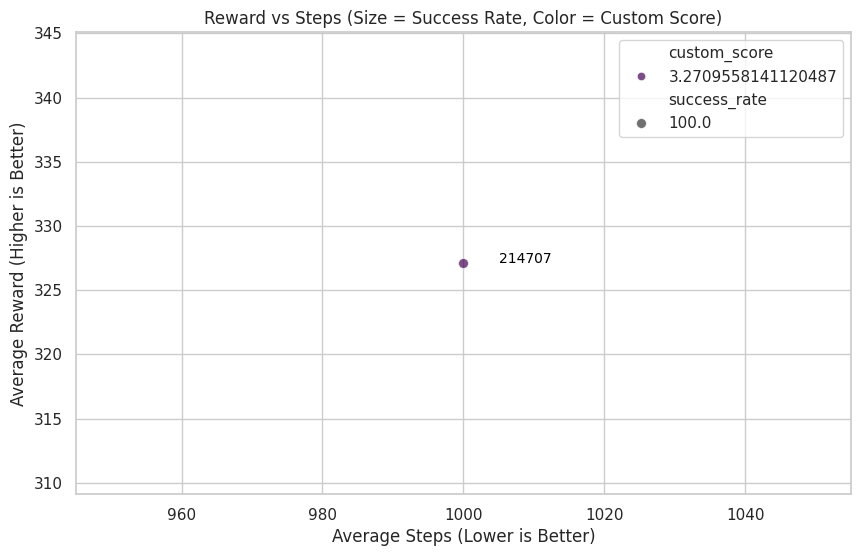

In [16]:
if not df.empty:
    plt.figure(figsize=(10, 6))
    scatter = sns.scatterplot(
        data=df, 
        x='avg_steps', 
        y='avg_reward', 
        size='success_rate', 
        hue='custom_score', 
        sizes=(50, 400), 
        palette='viridis',
        alpha=0.7
    )
    
    plt.title('Reward vs Steps (Size = Success Rate, Color = Custom Score)')
    plt.xlabel('Average Steps (Lower is Better)')
    plt.ylabel('Average Reward (Higher is Better)')
    
    # Add labels
    for line in range(0, df.shape[0]):
        plt.text(
            df.avg_steps.iloc[line]+5, 
            df.avg_reward.iloc[line], 
            df.timestamp.iloc[line][-6:], # Just show time
            horizontalalignment='left', 
            size='small', 
            color='black'
        )
        
    plt.show()
else:
    print("No data to plot.")

## 4. Hyperparameter Analysis
Select a hyperparameter to see its impact on the Custom Score.

In [17]:
import ipywidgets as widgets

if not df.empty and len(hp_cols) > 0:
    def plot_hp_impact(hp_name):
        plt.figure(figsize=(8, 5))
        # Check if numeric
        if pd.api.types.is_numeric_dtype(df[hp_name]):
            sns.regplot(data=df, x=hp_name, y='custom_score')
        else:
            sns.boxplot(data=df, x=hp_name, y='custom_score')
            sns.stripplot(data=df, x=hp_name, y='custom_score', color='black', alpha=0.5)
            
        plt.title(f'Impact of {hp_name} on Custom Score')
        plt.ylabel('Custom Score')
        plt.show()
    
    widgets.interact(plot_hp_impact, hp_name=sorted(hp_cols));
else:
    print("No hyperparameter data found.")

interactive(children=(Dropdown(description='hp_name', options=('hp_discount_factor', 'hp_exploration_rate', 'h…